## 基于 SqueezeNet 模型实现大疆无人机识别

该项目基于 SqueezeNet 算法，实现大疆无人机型号的识别，类别包括inspire、mavic、phantom和drone。

### 环境准备

In [3]:
%%capture captured_output
!pip uninstall mindspore -y
%env MINDSPORE_VERSION=2.5.0
!pip install https://ms-release.obs.cn-north-4.myhuaweicloud.com/${MINDSPORE_VERSION}/MindSpore/unified/aarch64/mindspore-${MINDSPORE_VERSION}-cp39-cp39-linux_aarch64.whl --trusted-host ms-release.obs.cn-north-4.myhuaweicloud.com -i https://pypi.tuna.tsinghua.edu.cn/simple

In [4]:
# 查看当前 mindspore 版本
!pip show mindspore

Name: mindspore
Version: 2.5.0
Summary: MindSpore is a new open source deep learning training/inference framework that could be used for mobile, edge and cloud scenarios.
Home-page: https://www.mindspore.cn
Author: The MindSpore Authors
Author-email: contact@mindspore.cn
License: Apache 2.0
Location: /home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages
Requires: asttokens, astunparse, dill, numpy, packaging, pillow, protobuf, psutil, safetensors, scipy
Required-by: 


### 超参设置

In [5]:
batch_size = 64  # 批量大小
image_size = 64  # 训练图像空间大小
workers = 4  # 并行线程个数
num_classes = 4  # 分类数量

### 数据集下载及数据处理

通过git下载魔乐平台的数据集。

In [6]:
!git lfs install
!git clone https://modelers.cn/xsir/dji.git
!unzip -q dji/dataset.zip -d ./dji

Git LFS initialized.
正克隆到 'dji'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 7 (delta 1), reused 0 (delta 0), pack-reused 0
接收对象中: 100% (7/7), 完成.
处理 delta 中: 100% (1/1), 完成.


In [7]:
import mindspore as ms
import mindspore.dataset as ds
import mindspore.dataset.vision as vision
from typing import Type, Union, List, Optional
from mindspore import nn, train
from mindspore.common.initializer import Normal
import os
import time
# 数据集目录路径
data_path_train = "./dji/dataset/train/"
data_path_val = "./dji/dataset/val/"

# 创建训练数据集

def create_dataset_canidae(dataset_path, usage):
    """数据加载"""
    data_set = ds.ImageFolderDataset(dataset_path,
                                     num_parallel_workers=workers,
                                     shuffle=True,)

    # 数据增强操作
    mean = [0.485 * 255, 0.456 * 255, 0.406 * 255]
    std = [0.229 * 255, 0.224 * 255, 0.225 * 255]
    scale = 32

    if usage == "train":
        # Define map operations for training dataset
        trans = [
            vision.RandomCropDecodeResize(size=image_size, scale=(0.08, 1.0), ratio=(0.75, 1.333)),
            vision.RandomHorizontalFlip(prob=0.5),
            vision.Normalize(mean=mean, std=std),
            vision.HWC2CHW()
        ]
    else:
        # Define map operations for inference dataset
        trans = [
            vision.Decode(),
            vision.Resize(image_size + scale),
            vision.CenterCrop(image_size),
            vision.Normalize(mean=mean, std=std),
            vision.HWC2CHW()
        ]


    # 数据映射操作
    data_set = data_set.map(
        operations=trans,
        input_columns='image',
        num_parallel_workers=workers)


    # 批量操作
    data_set = data_set.batch(batch_size)

    return data_set


dataset_train = create_dataset_canidae(data_path_train, "train")
step_size_train = dataset_train.get_dataset_size()

dataset_val = create_dataset_canidae(data_path_val, "val")
step_size_val = dataset_val.get_dataset_size()

/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [8]:
import matplotlib.pyplot as plt
import numpy as np

data_iter = next(dataset_train.create_dict_iterator())

images = data_iter["image"].asnumpy()
labels = data_iter["label"].asnumpy()
print(f"Image shape: {images.shape}, Label shape: {labels.shape}")

# 训练数据集中，前六张图片所对应的标签
print(f"Labels: {labels[:6]}")


# # 训练数据集的前六张图片
# plt.figure()
# for i in range(6):
#     plt.subplot(2, 3, i + 1)
#     image_trans = np.transpose(images[i], (1, 2, 0))
#     mean = np.array([0.4914, 0.4822, 0.4465])
#     std = np.array([0.2023, 0.1994, 0.2010])
#     image_trans = std * image_trans + mean
#     image_trans = np.clip(image_trans, 0, 1)
#     plt.title(f"{classes[labels[i]]}")
#     plt.imshow(image_trans)
#     plt.axis("off")
# plt.show()

Image shape: (64, 3, 64, 64), Label shape: (64,)
Labels: [0 0 3 2 3 3]


### SqueezeNet 模型

SqueezeNet 是一种轻量化卷积神经网络，专为高效压缩参数量而设计，由 DeepScale 和伯克利的研究团队于 2016 年提出。其核心目标是通过创新的网络架构设计，在维持高性能的前提下大幅降低模型复杂度。具体而言，它成功将模型参数量从 AlexNet 的 240MB 压缩至仅 4.8MB（减少了约 50 倍），同时保持了相同的分类精度（在 ImageNet 数据集上 Top-5 准确率达到约 80%），使其更适合移动端和边缘设备的部署。

#### 核心设计思想
SqueezeNet 的核心设计理念在于通过创新的架构设计和参数优化策略，在保持分类精度的同时显著减少模型参数量。其主要策略包括以下几点：
* 大量使用1x1卷积：广泛采用 1×1 卷积核来减少输入特征图的通道数，从而大幅降低计算复杂度。与 3×3 卷积相比，1×1 卷积不仅参数量更少，还能有效控制特征图的维度膨胀问题。
* 延迟下采样：将下采样操作推迟到网络后期执行，这种策略能够保留更多的空间信息，提升特征表达能力，同时有助于在网络早期提取细粒度特征。
* 引入 Fire 模块：SqueezeNet 的核心组件是 Fire 模块 ，它通过“压缩-扩展”结构在特征表达能力和参数效率之间取得平衡。

#### 核心组件：Fire 模块
Fire 模块是 SqueezeNet 的基本构建单元，由两个关键部分组成：Squeeze 层 和 Expand 层 。
* Squeeze 层
作用：通过 1×1 卷积核对输入特征图进行通道压缩，显著减少输入的通道数，从而降低后续计算的复杂度。
* Expand 层
作用：通过结合 1×1 和 3×3 卷积核，提取多尺度特征并增强模型的表达能力。其中 1×1 卷积提取局部特征，而 3×3 卷积则捕获更大范围的空间信息，两者的输出在通道维度上拼接，形成更加丰富的特征表示。

模型结构如下图所示，与残差版本的网络（如 ResNet）相比，摒弃跨层输入传递的设计，使模型结构更加紧凑、轻量化且高效。

![](https://openi.pcl.ac.cn/attachments/25ce9ba4-19b7-49eb-9403-058f3e1ee6bd?type=0)

In [9]:
import mindspore.nn as nn
from mindspore.common import initializer as weight_init
from mindspore.ops import operations as P


class Fire(nn.Cell):
    
    def __init__(self, inplanes, squeeze_planes, expand1x1_planes,
                 expand3x3_planes):
        super(Fire, self).__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes,
                                 squeeze_planes,
                                 kernel_size=1,
                                 has_bias=True)
        self.squeeze_activation = nn.ReLU()
        self.expand1x1 = nn.Conv2d(squeeze_planes,
                                   expand1x1_planes,
                                   kernel_size=1,
                                   has_bias=True)
        self.expand1x1_activation = nn.ReLU()
        self.expand3x3 = nn.Conv2d(squeeze_planes,
                                   expand3x3_planes,
                                   kernel_size=3,
                                   pad_mode='same',
                                   has_bias=True)
        self.expand3x3_activation = nn.ReLU()
        self.concat = P.Concat(axis=1)

    def construct(self, x):
        x = self.squeeze_activation(self.squeeze(x))
        return self.concat((self.expand1x1_activation(self.expand1x1(x)),
                            self.expand3x3_activation(self.expand3x3(x))))


class SqueezeNet(nn.Cell):
    
    def __init__(self, num_classes=10):
        super(SqueezeNet, self).__init__()

        self.features = nn.SequentialCell([
            nn.Conv2d(3,
                      96,
                      kernel_size=7,
                      stride=2,
                      pad_mode='valid',
                      has_bias=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            Fire(96, 16, 64, 64),
            Fire(128, 16, 64, 64),
            Fire(128, 32, 128, 128),
            nn.MaxPool2d(kernel_size=3, stride=2),
            Fire(256, 32, 128, 128),
            Fire(256, 48, 192, 192),
            Fire(384, 48, 192, 192),
            Fire(384, 64, 256, 256),
            nn.MaxPool2d(kernel_size=3, stride=2),
            Fire(512, 64, 256, 256),
        ])

        # Final convolution is initialized differently from the rest
        self.final_conv = nn.Conv2d(512,
                                    num_classes,
                                    kernel_size=1,
                                    has_bias=True)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
        self.mean = P.ReduceMean(keep_dims=True)
        self.flatten = nn.Flatten()
        self.custom_init_weight()

    def custom_init_weight(self):
        """
        Init the weight of Conv2d in the net.
        """
        for _, cell in self.cells_and_names():
            if isinstance(cell, nn.Conv2d):
                if cell is self.final_conv:
                    cell.weight.set_data(
                        weight_init.initializer('normal', cell.weight.shape,
                                                cell.weight.dtype))
                else:
                    cell.weight.set_data(
                        weight_init.initializer('he_uniform',
                                                cell.weight.shape,
                                                cell.weight.dtype))
                if cell.bias is not None:
                    cell.bias.set_data(
                        weight_init.initializer('zeros', cell.bias.shape,
                                                cell.bias.dtype))

    def construct(self, x):
        x = self.features(x)
        x = self.dropout(x)
        x = self.final_conv(x)
        x = self.relu(x)
        x = self.mean(x, (2, 3))
        x = self.flatten(x)

        return x

### 模型训练
跑了30epochs训练结果如下:

In [10]:
network = SqueezeNet(num_classes=4)

In [11]:
# 设置学习率
num_epochs = 30
lr = nn.cosine_decay_lr(min_lr=0.00001, max_lr=0.001, total_step=step_size_train * num_epochs,
                        step_per_epoch=step_size_train, decay_epoch=num_epochs)
# 定义优化器和损失函数
opt = nn.Momentum(params=network.trainable_params(), learning_rate=lr, momentum=0.9)
loss_fn = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')


def forward_fn(inputs, targets):
    logits = network(inputs)
    loss = loss_fn(logits, targets)
    return loss


grad_fn = ms.value_and_grad(forward_fn, None, opt.parameters)


def train_step(inputs, targets):
    loss, grads = grad_fn(inputs, targets)
    opt(grads)
    return loss

In [12]:
import os

# 创建迭代器
data_loader_train = dataset_train.create_tuple_iterator(num_epochs=num_epochs)
data_loader_val = dataset_val.create_tuple_iterator(num_epochs=num_epochs)

# 最佳模型存储路径
best_acc = 0
best_ckpt_dir = "./BestCheckpoint"
best_ckpt_path = "./BestCheckpoint/SqueezeNet-best.ckpt"

if not os.path.exists(best_ckpt_dir):
    os.mkdir(best_ckpt_dir)

In [13]:
import mindspore.ops as ops


def train(data_loader, epoch):
    """模型训练"""
    losses = []
    network.set_train(True)

    for i, (images, labels) in enumerate(data_loader):
        loss = train_step(images, labels)
        losses.append(loss)

    return sum(losses) / len(losses)


def evaluate(data_loader):
    """模型验证"""
    network.set_train(False)

    correct_num = 0.0  # 预测正确个数
    total_num = 0.0  # 预测总数

    for images, labels in data_loader:
        logits = network(images)
        pred = logits.argmax(axis=1)  # 预测结果
        correct = ops.equal(pred, labels).reshape((-1, ))
        correct_num += correct.sum().asnumpy()
        total_num += correct.shape[0]

    acc = correct_num / total_num  # 准确率

    return acc

In [14]:
# 开始循环训练
print("Start Training Loop ...")

for epoch in range(num_epochs):
    curr_loss = train(data_loader_train, epoch)
    curr_acc = evaluate(data_loader_val)
    if (epoch + 1) % 5 == 0:
        print("-" * 50)
        print("Epoch: [%3d/%3d], Average Train Loss: [%5.3f], Accuracy: [%5.3f]" % (
            epoch+1, num_epochs, curr_loss, curr_acc
        ))

    # 保存当前预测准确率最高的模型
    if curr_acc > best_acc:
        best_acc = curr_acc
        ms.save_checkpoint(network, best_ckpt_path)

print("=" * 80)
print(f"End of validation the best Accuracy is: {best_acc: 5.3f}, "
      f"save the best ckpt file in {best_ckpt_path}", flush=True)

Start Training Loop ...
........--------------------------------------------------
Epoch: [  5/ 30], Average Train Loss: [0.933], Accuracy: [0.500]
--------------------------------------------------
Epoch: [ 10/ 30], Average Train Loss: [0.681], Accuracy: [0.790]
--------------------------------------------------
Epoch: [ 15/ 30], Average Train Loss: [0.513], Accuracy: [0.845]
--------------------------------------------------
Epoch: [ 20/ 30], Average Train Loss: [0.420], Accuracy: [0.905]
--------------------------------------------------
Epoch: [ 25/ 30], Average Train Loss: [0.392], Accuracy: [0.935]
--------------------------------------------------
Epoch: [ 30/ 30], Average Train Loss: [0.373], Accuracy: [0.930]
End of validation the best Accuracy is:  0.945, save the best ckpt file in ./BestCheckpoint/SqueezeNet-best.ckpt


### 可视化模型预测
定义`visualize_model`函数，使用上述验证精度最高的模型对测试数据集进行预测，并将预测结果可视化。若预测字体颜色为蓝色表示为预测正确，预测字体颜色为红色则表示预测错误。

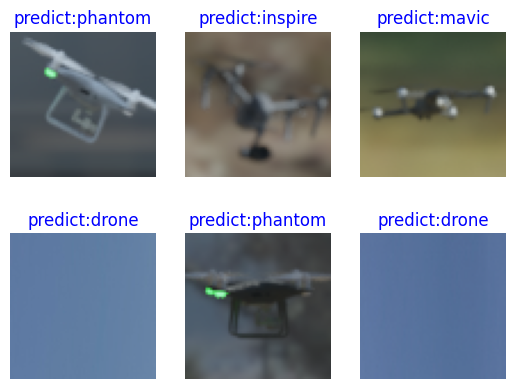

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_model(best_ckpt_path, dataset_val):
    net = SqueezeNet(num_classes=4)
    # 加载模型参数
    param_dict = ms.load_checkpoint(best_ckpt_path)
    ms.load_param_into_net(net, param_dict)
    # 加载验证集的数据进行验证
    data = next(dataset_val.create_dict_iterator())
    images = data["image"]
    labels = data["label"]
    # 预测图像类别
    output = net(data['image'])
    pred = np.argmax(output.asnumpy(), axis=1)

    # 图像分类
    classes = ["inspire", "mavic", "phantom", "drone"]

    # 显示图像及图像的预测值
    plt.figure()
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        # 若预测正确，显示为蓝色；若预测错误，显示为红色
        color = 'blue' if pred[i] == labels.asnumpy()[i] else 'red'
        plt.title('predict:{}'.format(classes[pred[i]]), color=color)
        picture_show = np.transpose(images.asnumpy()[i], (1, 2, 0))
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.2023, 0.1994, 0.2010])
        picture_show = std * picture_show + mean
        picture_show = np.clip(picture_show, 0, 1)
        plt.imshow(picture_show)
        plt.axis('off')

    plt.show()


# 使用测试数据集进行验证
visualize_model(best_ckpt_path=best_ckpt_path, dataset_val=dataset_val)